In [39]:
import numpy as np
from tensorflow.keras.layers import BatchNormalization,Dropout,MaxPooling2D,Reshape, Input, concatenate,Embedding,multiply,Flatten
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LeakyReLU,ReLU, UpSampling2D, Conv2D,Conv2DTranspose,Concatenate,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
from tensorflow import random_normal_initializer,reduce_mean,abs,ones_like,zeros_like


In [37]:
image_shape=[256,256,3]
OUTPUT_CHANNELS=3
LAMBDA=100
object_loss=BinaryCrossentropy(from_logits=True)

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(BatchNormalization())

  result.add(LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(BatchNormalization())

  if apply_dropout:
      result.add(Dropout(0.5))

  result.add(ReLU())

  return result

In [ ]:
def Generator():
  inputs = Input(shape=image_shape)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = random_normal_initializer(0., 0.02)
  last = Conv2DTranspose(OUTPUT_CHANNELS, 4,strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = Concatenate()([x, skip])

  x = last(x)

  return Model(inputs=inputs, outputs=x)

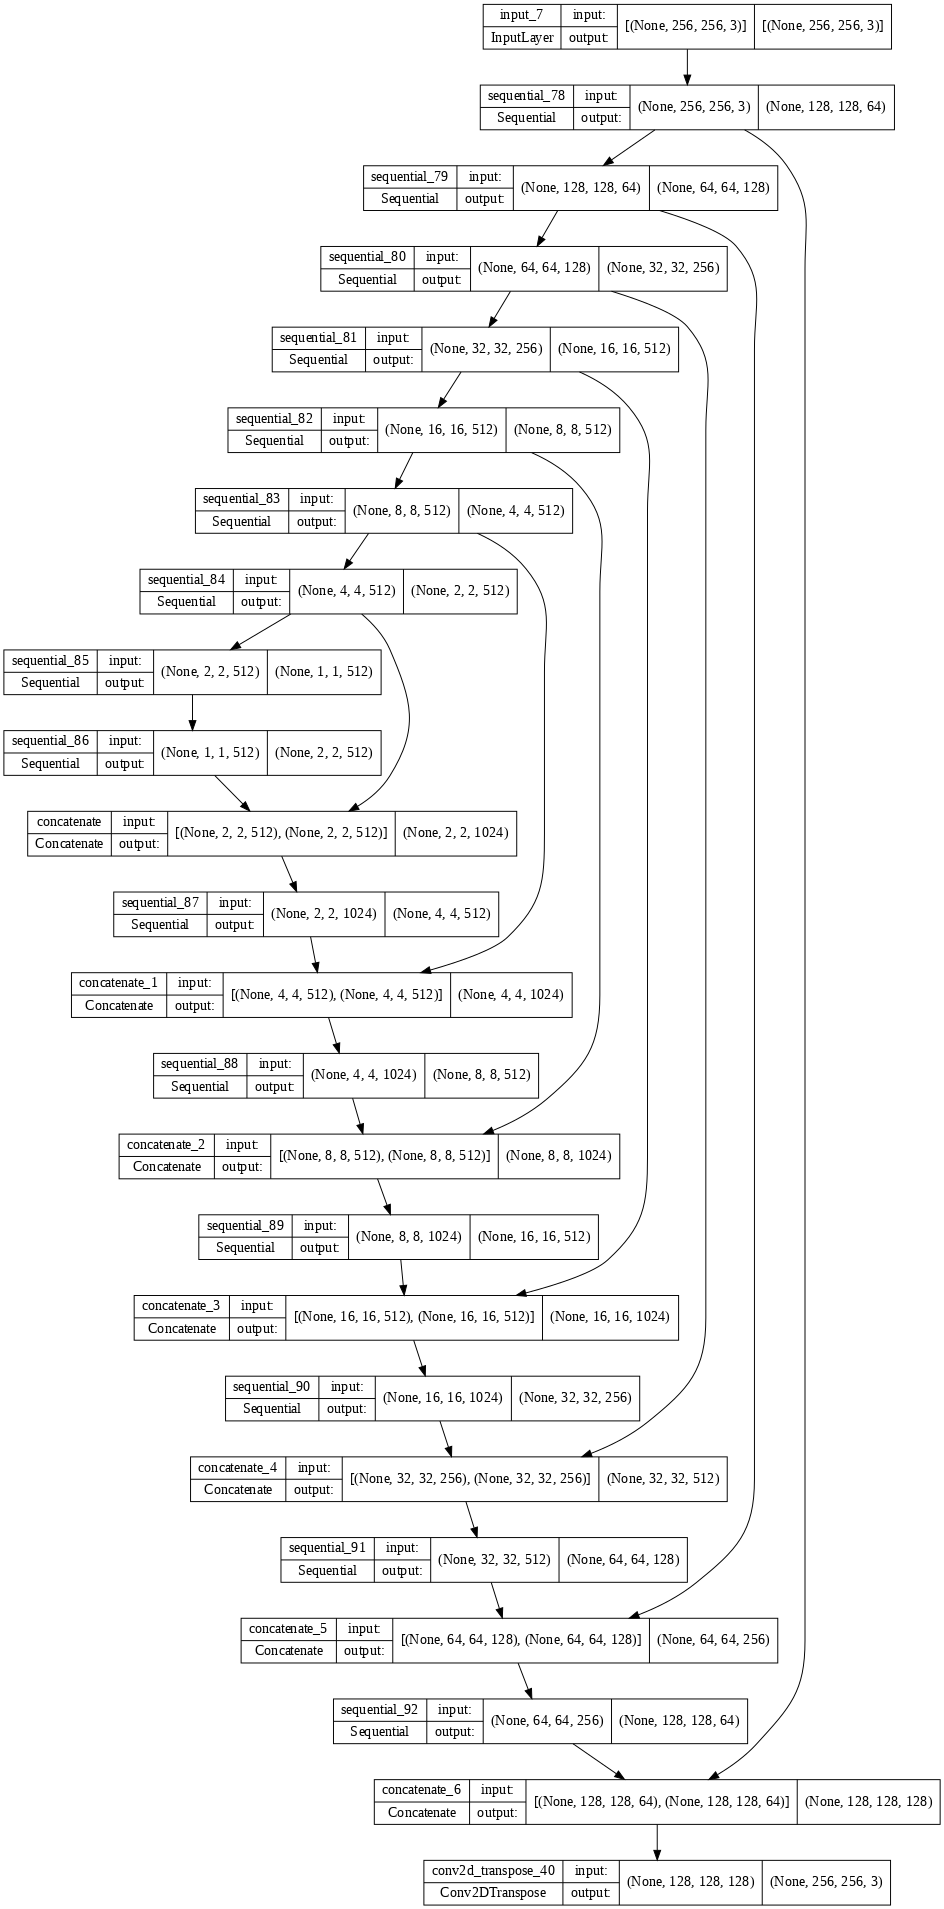

In [ ]:
generator=Generator()
plot_model(generator,show_shapes=True,dpi=70)

In [38]:

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = object_loss(ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = reduce_mean(abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = random_normal_initializer(0., 0.02)

  inp = Input(shape=[256, 256, 3], name='input_image')
  tar = Input(shape=[256, 256, 3], name='target_image')

  x = concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = Conv2D(512, 4, strides=1,kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = BatchNormalization()(conv)

  leaky_relu = LeakyReLU()(batchnorm1)

  zero_pad2 = ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = Conv2D(1, 4, strides=1,kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return Model(inputs=[inp, tar], outputs=last)


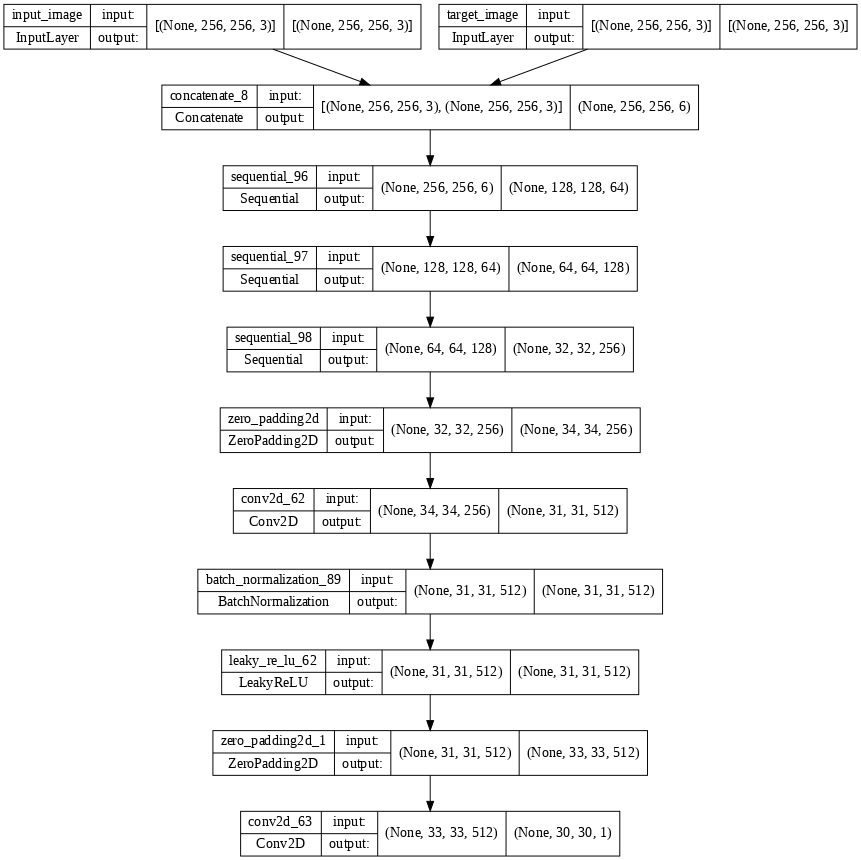

In [ ]:
discriminator=Discriminator()
plot_model(discriminator,show_shapes=True,dpi=70)

In [40]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = object_loss(ones_like(disc_real_output), disc_real_output)

  generated_loss = object_loss(zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss